French Fake News Detection model with camemBERT model

This notebook contains : 
- Exploration of news
- Preparation input data
- Training camemBERT Sequence Classification (using "simpletransformers")
- Evaluation

Works on Google Colab 
- Choose GPU  Execution type


## Installation

In [1]:
!pip install simpletransformers

     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 204kB 5.1MB/s 
     |████████████████████████████████| 450kB 6.3MB/s 
     |████████████████████████████████| 1.4MB 8.0MB/s 
     |████████████████████████████████| 1.0MB 19.7MB/s 
     |████████████████████████████████| 870kB 25.5MB/s 
     |████████████████████████████████| 92kB 12.0MB/s 
     |████████████████████████████████| 102kB 9.4MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 460kB 30.2MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=c3e11dde8997ba992ed8afe5e66f1b6461d155a48ecb16005a0c5fd45b72b1a3
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl

## Import

In [2]:
%matplotlib inline

# for figure
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

# for training
from simpletransformers.classification import ClassificationModel

# to save 
import pickle
from sklearn.externals import joblib

# useful
import pandas as pd
import numpy as np
import numpy.ma as ma
import shutil
import os
import re
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# for cross validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Definitions

In [3]:
# your data folder
PATH_FOLDER_SAVE = '/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data'
# your code folder 
PATH_FOLDER_CODE = \
  "/content/drive/My Drive/OpenClassRooms/IML_Projet_7/code/FakeNewsDetectionFr"
# path current
path_current = os.getcwd()
# path of model  during training : big amount of data :
path_folder_model_curr = path_current + '/outputs'
# path folder saved model
PATH_FOLDER_MODEL_SAVED = '/content/drive/My Drive/outputs_proj7'
# list of camemBERT model files to save
LIST_FILES_TO_SAVE = ["added_tokens.json", "config.json", "eval_results.txt",
                      "pytorch_model.bin" ,"sentencepiece.bpe.model", 
                      "special_tokens_map.json", "tokenizer_config.json", 
                      "training_args.bin"]
# path of DATA
PATH_DF_FAKE_NEWS = PATH_FOLDER_SAVE + '/df_fake_news.pkl'
PATH_DF_TRUE_NEWS = PATH_FOLDER_SAVE + '/df_true_news.pkl'

# % of data used for training
train_percent = 0.7
# maximum number of epochs limited by disk space (1 epoch = 1Gb of data)                    
MAX_NB_EPOCHS = 33 
# random state for training and other stuff
RANDOM_STATE = 0

# save df news
PATH_DF_NEWS_SAVE = PATH_FOLDER_SAVE + '/df_news.pkl' 
# save df results
PATH_DF_RES_SAVE = PATH_FOLDER_SAVE + '/df_res.pkl'

# check if Google Colab need Drive ?
if re.match("^/content", os.getcwd()):
    print("GOOGLE COLAB MODE")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    os.chdir(PATH_FOLDER_CODE)

GOOGLE COLAB MODE
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Useful functions

In [0]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

def save_model_folder(path_folder_source, path_folder_dest):
  '''
  Save model folder to be reused
  '''
  
  if os.path.isdir(path_folder_dest) == False:
    os.mkdir(path_folder_dest)
  for file_curr in LIST_FILES_TO_SAVE:
    shutil.copyfile(path_folder_source + '/' + file_curr, 
                    path_folder_dest + '/' + file_curr)

def check_file_permissions(file_name):
  '''
  Python program to get file permission mask 
  of a given file
  '''

  # Get the file permission mask 
  # of the specified file 
  mask = oct(os.stat(file_name).st_mode)[-3:] 
  
  # Print the mask 
  print("File permission mask:", mask) 


def plot_confusion_matrix(y_true, y_pred, classes, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    V2.0 : 18/01/2019 : G.LANG : correction nan value for color
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    mask_test = ma.masked_invalid(cm)
    thresh = mask_test.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

def train_model_cam(train_df, eval_df, path_to_save=PATH_FOLDER_MODEL_SAVED,
                    use_cuda=True):
  # loop to train without override disk usage
  list_acc_train = []
  list_acc_test = []
  for num_serie in range(0, 10):
    print("Run #", num_serie)
    # Create a ClassificationModel
    # You can set class weights by using the optional weight argument
    model = ClassificationModel('camembert', 'camembert-base', 
                                use_cuda=use_cuda) 
    # Train the model
    model.train_model(train_df, 
                      args={'fp16': False, 
                            'overwrite_output_dir': True,
                            'num_train_epochs': MAX_NB_EPOCHS})

    # Evaluate the model
    result, model_outputs, wrong_predictions = model.eval_model(eval_df)
    print(result)
    
    # eval train
    y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
    acc_train = accuracy_score(train_df["fake"], y_train_pred)
    print("acc_train: ", acc_train)
    list_acc_train.append(acc_train)
    # eval test
    y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
    acc_test = accuracy_score(eval_df["fake"], y_test_pred)
    print("acc_test: ", acc_test)
    list_acc_test.append(acc_test)

    if (acc_test >= np.max(list_acc_test)):
      # Save model
      save_model_folder(path_folder_model_curr, path_to_save)
      result_best = result

  print("list_acc_train: ", list_acc_train)  
  print("list_acc_test: ", list_acc_test)    
  print("best result: ", result_best)
  print("best acc_test: ", np.max(list_acc_train))
  print("best acc_test: ", np.max(list_acc_test))

In [7]:
check_file_permissions("/content/drive/My Drive/OpenClassRooms/IML_Projet_7/code/FakeNewsDetectionFr/README.md")

File permission mask: 600


## Prepare Data 

### Concatenate news sources 

In [0]:
df_true = joblib.load(PATH_DF_TRUE_NEWS)
df_fake = joblib.load(PATH_DF_FAKE_NEWS)

In [0]:
df_true = df_true.filter(items=["url", "source", "author", "title", "theme", 
                      "description", "date_published", "body"])
df_fake = df_fake.filter(items=["url", "source", "author", "title", "theme", 
                      "description", "date_published", "body"])

In [0]:
df_true["fake"] = 0
df_fake["fake"] = 1

In [0]:
df_news = pd.concat([df_true, df_fake], ignore_index=True)

In [10]:
df_news.shape

(2534, 9)

nb_missing      ratio
url                      0   0.000000
source                   0   0.000000
author                   0   0.000000
title                    0   0.000000
theme                    0   0.000000
date_published           0   0.000000
body                     0   0.000000
fake                     0   0.000000
description            453  17.876875

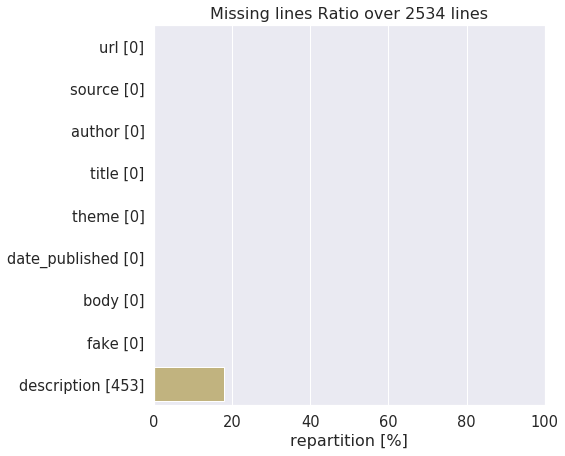

In [0]:
display_missing(df_news)

### Explore sources

In [0]:
df_news["source"].value_counts()

LeGorafi           621
20Minutes          585
Liberation         333
Futura Sciences    317
Buzzbeed           240
Nordpresse         211
Telerama           101
Le Monde            66
Le Figaro           60
Name: source, dtype: int64

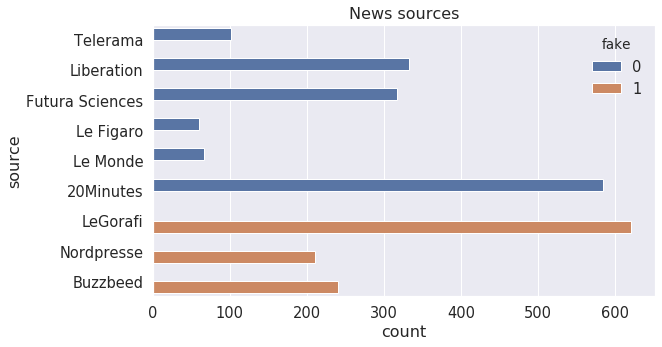

In [0]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("News sources")
ax = sns.countplot(y="source", hue="fake", data=df_news)

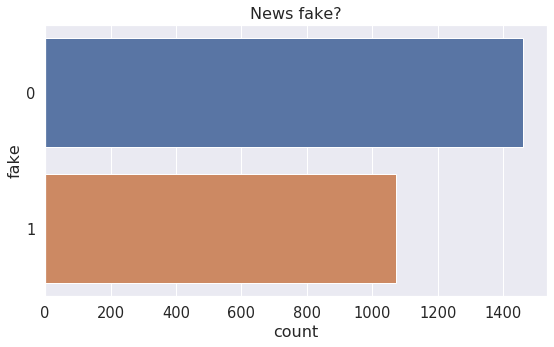

In [0]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("News fake?")
ax = sns.countplot(y="fake", data=df_news)

### Balance news sources/themes

In [0]:
df_news.shape

(2534, 9)

In [0]:
# delete Telerama source not appropriate 
df_news = df_news[df_news["source"] != "Telerama"]
df_news.shape

(2433, 9)

In [0]:

'''# reduce by half Futura Science news number
df_fs = df_news[df_news["source"] == "Futura Sciences"]
df_fs = df_fs.head(np.int(df_fs.shape[0]/2))

# delete source not appropriate 
df_news = df_news[df_news["source"] != "Futura Sciences"]
# add half
df_news = pd.concat([df_news, df_fs], ignore_index=True, sort=False)
df_news.shape'''

(2274, 9)

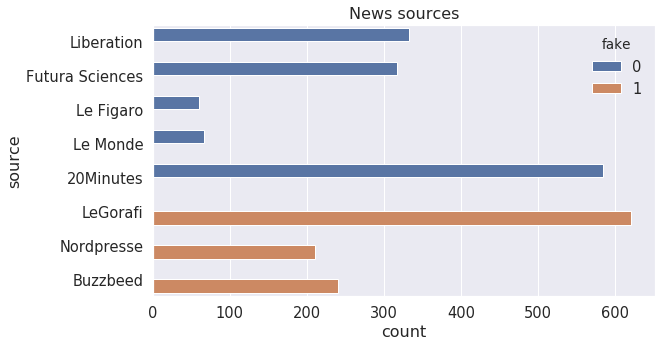

In [0]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("News sources")
ax = sns.countplot(y="source", hue="fake", data=df_news)

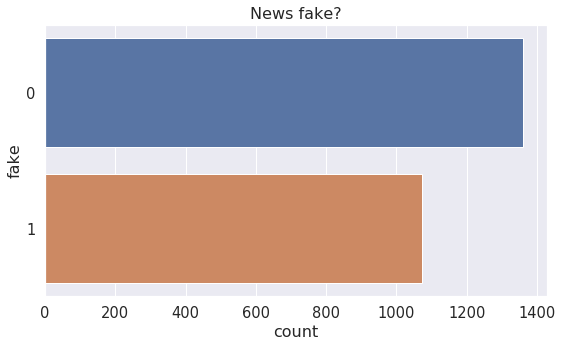

In [0]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("News fake?")
ax = sns.countplot(y="fake", data=df_news)

### Concatenate Title & Body

In [0]:
# prepare format data
df_news["text"] = df_news["title"] + " " + df_news["body"]

In [0]:
df_news.head()

url  ...                                               text
1  https://www.liberation.fr/france/2019/12/15/le...  ...  Les chefs de service hospitaliers en appellent...
2  https://www.futura-sciences.com/sante/actualit...  ...  L'origine des comportements alimentaires ident...
3  https://www.futura-sciences.com/tech/actualite...  ...  Microsoft alerte sur de nouvelles techniques d...
4  https://www.futura-sciences.com/sciences/actua...  ...  L'Europe se dote d'une infrastructure de téléc...
6  https://www.futura-sciences.com/sciences/actua...  ...  Science décalée : la créature la plus rapide s...

[5 rows x 10 columns]

### Separate TRAIN/TEST Data

In [0]:
np.random.seed(0)
indices_permut = np.random.permutation(df_news.shape[0])
df_news['train'] = False
indices_permut_train = indices_permut[0:np.int(len(indices_permut)*train_percent)]
df_news['train'].iloc[indices_permut_train] = True
df_news['train'].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


True     1703
False     730
Name: train, dtype: int64

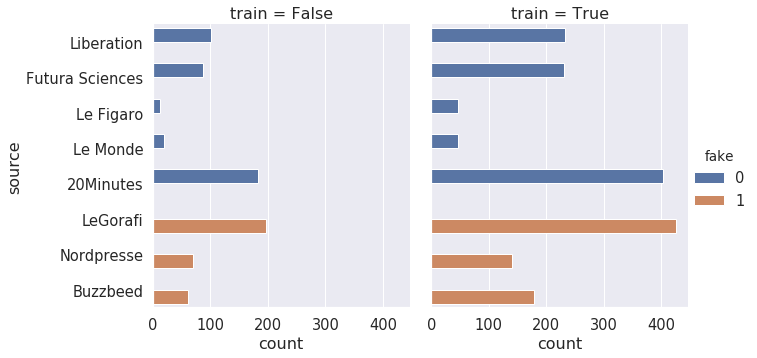

In [0]:
sns.catplot(y="source", hue="fake", col="train", data=df_news, kind="count",
                height=5, aspect=1);
#plt.title("News sources")

### Explore themes

In [0]:
df_news["theme"].nunique()

60

In [0]:
df_news["theme"].unique()

array(['france', 'sante', 'tech', 'sciences', 'planete', 'debats',
       'sports', 'chroniques', 'article', 'maison', 'actu conseils',
       'fonds', 'indices', 'indices actions', 'politiques',
       'evenements libe', 'culture', 'international', 'pixels', 'm perso',
       'afrique', 'politique', 'economie', 'societe', 'football', 'idees',
       'm le mag', 'sport', 'police justice', 'Société', 'Politique',
       'France', 'Economie', 'Sciences', 'Culture', 'Hi-Tech',
       'Gilets Jaunes', 'Start Up Nation', 'Monde', 'Technologies',
       'Violence', 'Sports', 'Religion', 'Medias', 'People', 'Non classé',
       'Honteux', 'Médecine', 'Justice', 'Sexe', 'Insolite',
       'Uncategorized', "Sentiment d'insécurité", 'Préserver la planète',
       'Justice sociale', 'Économie', 'Vivre ensemble', 'Fait divers',
       'Fenêtre sur le monde', 'Fake news'], dtype=object)

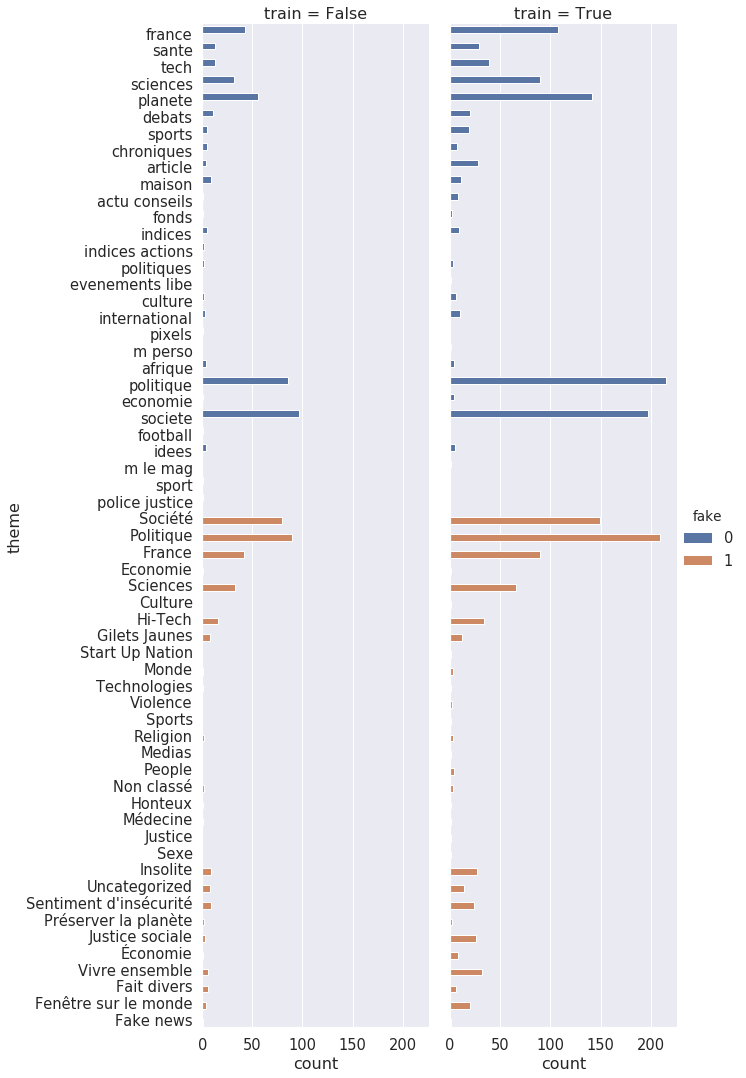

In [0]:
sns.catplot(y="theme", hue="fake", col="train", data=df_news, kind="count",
                height=15, aspect=0.33);

In [0]:
df_news.loc[df_news["theme"] == "France", "theme"] = "france"

In [0]:
df_news.loc[df_news["theme"] == "Médecine", "theme"] = "sante"

In [0]:
df_news.loc[df_news["theme"] == "Technologies", "theme"] = "tech"
df_news.loc[df_news["theme"] == "pixels", "theme"] = "tech"
df_news.loc[df_news["theme"] == "Hi-Tech", "theme"] = "tech"



In [0]:
df_news.loc[df_news["theme"] == "Préserver la planète", "theme"] = "planete"

In [0]:
df_news.loc[df_news["theme"] == "series tv", "theme"] = "television"

In [0]:
df_news.loc[df_news["theme"] == "radio", "theme"] = "medias"

In [0]:
df_news.loc[df_news["theme"] == "Medias", "theme"] = "medias"

In [0]:
df_news.loc[df_news["theme"] == "Sports", "theme"] = "sports"

In [0]:
df_news.loc[df_news["theme"] == "football", "theme"] = "sports"

In [0]:
df_news.loc[df_news["theme"] == "sport", "theme"] = "sports"

In [0]:
df_news.loc[df_news["theme"] == "international", "theme"] = "monde"

In [0]:
df_news.loc[df_news["theme"] == "afrique", "theme"] = "monde"

In [0]:
df_news.loc[df_news["theme"] == "Monde", "theme"] = "monde"

In [0]:
df_news.loc[df_news["theme"] == "Fenêtre sur le monde", "theme"] = "monde"

In [0]:
df_news.loc[df_news["theme"] == "indices", "theme"] = "economie"
df_news.loc[df_news["theme"] == "indices actions", "theme"] = "economie"
df_news.loc[df_news["theme"] == "fonds", "theme"] = "economie"
df_news.loc[df_news["theme"] == "Economie", "theme"] = "economie"
df_news.loc[df_news["theme"] == "Économie", "theme"] = "economie"

In [0]:
df_news.loc[df_news["theme"] == "politiques", "theme"] = "politique"
df_news.loc[df_news["theme"] == "Politique", "theme"] = "politique"

In [0]:
df_news.loc[df_news["theme"] == "Société", "theme"] = "societe"

In [0]:
df_news.loc[df_news["theme"] == "Uncategorized", "theme"] = "non classe"
df_news.loc[df_news["theme"] == "Non classé", "theme"] = "non classe"

In [0]:
df_news.loc[df_news["theme"] == "scenes", "theme"] = "culture"
df_news.loc[df_news["theme"] == "musique", "theme"] = "culture"
df_news.loc[df_news["theme"] == "livre", "theme"] = "culture"

In [0]:
df_news.loc[df_news["theme"] == "Sciences", "theme"] = "sciences"

In [0]:
df_news[df_news["theme"] == "Culture"]["description"].tolist()

['Plus de huit ans déjà que les scientifiques cherchent à résoudre la fameuse opération de la chanson de Grégoire et toujours aucun résultat. Malgré tout, ils refusent d’abandonner le combat.']

In [0]:
df_news[df_news["theme"] == "evenements libe"]["description"].tolist()

["Environnement, social, éducation, consommation... Ils s'engagent au quotidien. Aujourd'hui Etienne Bourgois, président de la Fondation Tara Océan."]

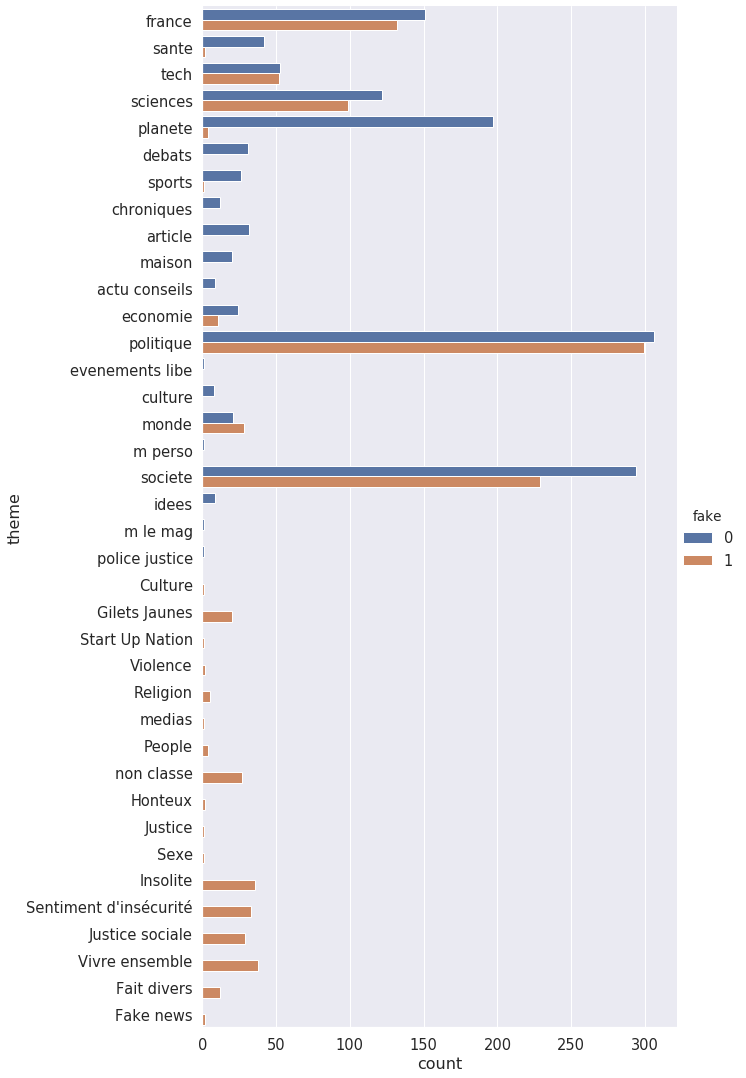

In [0]:
sns.catplot(y="theme", hue="fake",  data=df_news, kind="count",
                height=15, aspect=0.66);

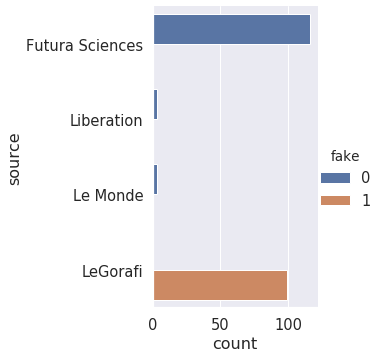

In [0]:
sns.catplot(y="source", hue="fake", data=df_news[df_news["theme"] =="sciences"],
            kind="count");

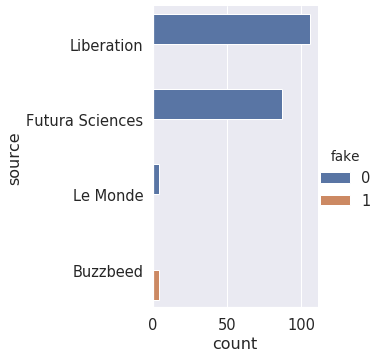

In [0]:
sns.catplot(y="source", hue="fake", data=df_news[df_news["theme"] =="planete"],
            kind="count");

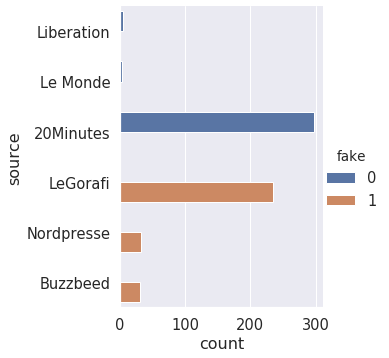

In [0]:
sns.catplot(y="source", hue="fake", 
            data=df_news[df_news["theme"] =="politique"],
            kind="count");

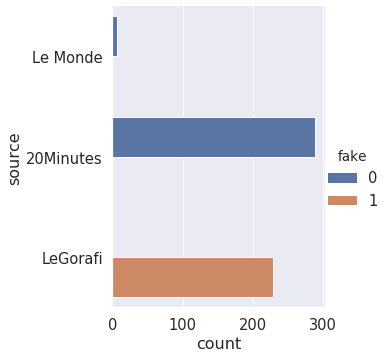

In [0]:
sns.catplot(y="source", hue="fake", 
            data=df_news[df_news["theme"] =="societe"],
            kind="count");

### Number of words per news

In [0]:
def count_words_in_sentence(str_sentence):
  return len(str_sentence.split())

df_news["nb_words"] = df_news["body"].apply(count_words_in_sentence)

(0, 2000)

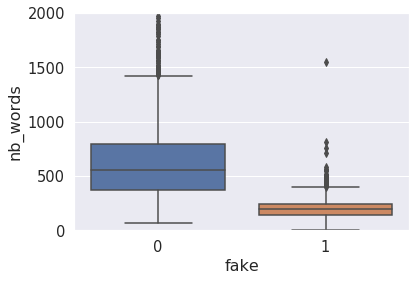

In [0]:
ax = sns.boxplot(x="fake", y="nb_words", data=df_news)

ax.set_ylim([0, 2000])

In [0]:
df_news["nb_words"].max()

89028

In [0]:
# https://nordpresse.be/enfant-noye-mexique-famille-petit-alan-porte-plainte-plagiat/

df_news[df_news["nb_words"] > 80000]

url  ... nb_words
2171  https://nordpresse.be/enfant-noye-mexique-fami...  ...    89028

[1 rows x 12 columns]

In [0]:
df_news[df_news["nb_words"] >80000].index.tolist()

[2171]

In [0]:
df_news.drop(df_news[df_news["nb_words"] >80000].index.tolist(),
             inplace=True)

In [0]:
df_news[df_news["nb_words"] > 80000].shape[0]

0

#### By sources

(0, 2200)

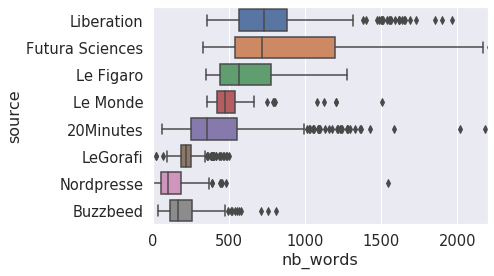

In [22]:
ax = sns.boxplot(y="source", x="nb_words", data=df_news, orient="h")
ax.set_xlim([0, 2200])

### Save Data

In [0]:
joblib.dump(df_news, PATH_DF_NEWS_SAVE)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/df_news.pkl']

### Load Data

In [0]:
df_news = joblib.load(PATH_DF_NEWS_SAVE)

### Format data

Train and Evaluation data needs to be in a Pandas Dataframe of two columns. 

The first column is the text with type str, 
and the second column is the label with type int.

In [0]:
df_news.filter(items=["text", "fake"])

text  fake
1     Les chefs de service hospitaliers en appellent...     0
2     L'origine des comportements alimentaires ident...     0
3     Microsoft alerte sur de nouvelles techniques d...     0
4     L'Europe se dote d'une infrastructure de téléc...     0
6     Science décalée : la créature la plus rapide s...     0
...                                                 ...   ...
2529  97% de Libanaises refaites : L’ONU demande au ...     1
2530  Un réfugié syrien humilie et empêche une famil...     1
2531  Mehdi Meklat lance une banane à Christiane Tau...     1
2532  En visite en Afghanistan, Marine Le Pen refuse...     1
2533  Insolite : il supprime 50 000 tweets en une nu...     1

[2432 rows x 2 columns]

In [0]:
# Train and Evaluation data needs to be in a Pandas Dataframe of two columns. 
train_df = df_news.filter(items=["text", "fake"])[df_news["train"] == True]
eval_df = df_news.filter(items=["text", "fake"])[df_news["train"] == False]

# CamemBERT




### Train model learning_rate : 4e-5

#### First Epochs

In [21]:
print("Folder of final trained model: ", PATH_FOLDER_MODEL_SAVED)

Folder of final trained model:  /content/drive/My Drive/outputs_proj7


In [10]:
train_model_cam(train_df, eval_df, path_to_save=PATH_FOLDER_MODEL_SAVED)

Run # 0
Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:139: UserWarning: use_multiprocessing automatically disabled as camembert fails when using multiprocessing for feature conversion.
  warnings.warn(f"use_multiprocessing automatically disabled as {model_type} fails when using multiprocessing for feature conversion.")
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:183: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")


Running loss: 0.314926

Running loss: 0.017439

Running loss: 0.004102

Running loss: 0.001907

Running loss: 0.001202

Running loss: 0.000634

Running loss: 0.000444

Running loss: 0.000292

Running loss: 0.000164

Running loss: 0.000166

Running loss: 0.000157

Running loss: 0.000417

Running loss: 0.000152

Running loss: 0.000117

Running loss: 0.000105

Running loss: 0.000077

Running loss: 0.000065

Running loss: 0.000078

Running loss: 0.000071

Running loss: 0.000044

Running loss: 0.000044

Running loss: 0.000033

Running loss: 0.000027

Running loss: 0.000034

Running loss: 0.000024

Running loss: 0.000028

Running loss: 0.000039

Running loss: 0.000040

Running loss: 0.000032

Running loss: 0.000031

Running loss: 0.000028

Running loss: 0.000026

Running loss: 0.000022
Training of camembert model complete. Saved to outputs/.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:458: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")


Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.8863333122066007, 'tp': 288, 'tn': 399, 'fp': 4, 'fn': 38, 'eval_loss': 0.49484073046756827}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.9423868312757202
Run # 1
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.107332

Running loss: 0.023286

Running loss: 0.005450

Running loss: 0.001679

Running loss: 0.000789

Running loss: 0.000578

Running loss: 0.001374

Running loss: 0.000323

Running loss: 0.000236

Running loss: 0.000191

Running loss: 0.000111

Running loss: 0.000119

Running loss: 0.000099

Running loss: 0.000095

Running loss: 0.000078

Running loss: 0.000060

Running loss: 0.000049

Running loss: 0.000046

Running loss: 0.000033

Running loss: 0.000032

Running loss: 0.000042

Running loss: 0.000059

Running loss: 0.000086

Running loss: 0.000067

Running loss: 0.000045

Running loss: 0.000034

Running loss: 0.000034

Running loss: 0.000029

Running loss: 0.000028

Running loss: 0.000026

Running loss: 0.000026

Running loss: 0.000022

Running loss: 0.000019
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.9084274168179179, 'tp': 306, 'tn': 390, 'fp': 13, 'fn': 20, 'eval_loss': 0.36038195058379485}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.9547325102880658
Run # 2
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.428982

Running loss: 0.973347

Running loss: 0.742996

Running loss: 0.001270

Running loss: 0.000647

Running loss: 0.000353

Running loss: 0.000289

Running loss: 0.000250

Running loss: 0.000197

Running loss: 0.000144

Running loss: 0.000128

Running loss: 0.000092

Running loss: 0.000180

Running loss: 0.000145

Running loss: 0.000084

Running loss: 0.000073

Running loss: 0.000095

Running loss: 0.000062

Running loss: 0.000052

Running loss: 0.000042

Running loss: 0.000042

Running loss: 0.000037

Running loss: 0.000027

Running loss: 0.000028

Running loss: 0.000027

Running loss: 0.000022

Running loss: 0.000022

Running loss: 0.000023

Running loss: 0.000018

Running loss: 0.000026

Running loss: 0.000020

Running loss: 0.000019

Running loss: 0.000023
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.9280119634826597, 'tp': 308, 'tn': 395, 'fp': 8, 'fn': 18, 'eval_loss': 0.36811805897108885}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.9643347050754458
Run # 3
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.418814

Running loss: 0.076715

Running loss: 0.005269

Running loss: 0.002291

Running loss: 0.001211

Running loss: 0.000654

Running loss: 0.000491

Running loss: 0.000282

Running loss: 0.000400

Running loss: 0.000272

Running loss: 0.000185

Running loss: 1.225247

Running loss: 0.000195

Running loss: 0.000112

Running loss: 0.000149

Running loss: 0.000093

Running loss: 0.000075

Running loss: 0.000068

Running loss: 0.000065

Running loss: 0.000059

Running loss: 0.000057

Running loss: 0.000037

Running loss: 0.000107

Running loss: 0.000092

Running loss: 0.000061

Running loss: 0.000031

Running loss: 0.000038

Running loss: 0.000045

Running loss: 0.000032

Running loss: 0.000028

Running loss: 0.000025

Running loss: 0.000027

Running loss: 0.000032
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.8968036588786095, 'tp': 292, 'tn': 399, 'fp': 4, 'fn': 34, 'eval_loss': 0.46383298091266467}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.9478737997256516
Run # 4
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.146911

Running loss: 0.031675

Running loss: 0.708127

Running loss: 0.003135

Running loss: 0.001008

Running loss: 0.000630

Running loss: 0.000412

Running loss: 0.000278

Running loss: 0.000252

Running loss: 0.000194

Running loss: 0.000145

Running loss: 0.000166

Running loss: 0.000097

Running loss: 0.030531

Running loss: 0.000080

Running loss: 0.000068

Running loss: 0.000059

Running loss: 0.000043

Running loss: 0.000040

Running loss: 0.000039

Running loss: 0.000035

Running loss: 0.000034

Running loss: 0.000027

Running loss: 0.000029

Running loss: 0.000024

Running loss: 0.000029

Running loss: 0.000038

Running loss: 0.000023

Running loss: 0.000035

Running loss: 0.000023

Running loss: 0.000027

Running loss: 0.000030

Running loss: 0.000019
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.9065262128119097, 'tp': 299, 'tn': 396, 'fp': 7, 'fn': 27, 'eval_loss': 0.4185398736887652}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.953360768175583
Run # 5
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.094603

Running loss: 0.524694

Running loss: 0.004868

Running loss: 0.004794

Running loss: 0.000877

Running loss: 0.000638

Running loss: 0.000402

Running loss: 0.000620

Running loss: 0.000295

Running loss: 0.000169

Running loss: 0.000170

Running loss: 0.000179

Running loss: 0.000093

Running loss: 0.000116

Running loss: 0.000087

Running loss: 0.000063

Running loss: 0.000056

Running loss: 0.000044

Running loss: 0.000051

Running loss: 0.000048

Running loss: 0.000039

Running loss: 0.000038

Running loss: 0.000033

Running loss: 0.000022

Running loss: 0.000034

Running loss: 0.000023

Running loss: 0.000027

Running loss: 0.000021

Running loss: 0.000022

Running loss: 0.000016

Running loss: 0.000018

Running loss: 0.000020

Running loss: 0.000020
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.9281282394787194, 'tp': 307, 'tn': 396, 'fp': 7, 'fn': 19, 'eval_loss': 0.313132089684191}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.9643347050754458
Run # 6
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.841482

Running loss: 0.032447

Running loss: 0.496930

Running loss: 0.002664

Running loss: 0.000927

Running loss: 0.000677

Running loss: 0.000495

Running loss: 0.000349

Running loss: 0.000231

Running loss: 0.000209

Running loss: 0.000247

Running loss: 0.000176

Running loss: 0.000105

Running loss: 0.000163

Running loss: 0.000118

Running loss: 0.000159

Running loss: 0.000070

Running loss: 0.000073

Running loss: 0.000064

Running loss: 0.000073

Running loss: 0.164597

Running loss: 0.000044

Running loss: 0.000047

Running loss: 0.000036

Running loss: 0.000028

Running loss: 0.000027

Running loss: 0.000026

Running loss: 0.000024

Running loss: 0.000019

Running loss: 0.000017

Running loss: 0.000017

Running loss: 0.000020

Running loss: 0.000016
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.9090069773033321, 'tp': 301, 'tn': 395, 'fp': 8, 'fn': 25, 'eval_loss': 0.43616648471873737}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.9547325102880658
Run # 7
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.713051

Running loss: 0.017689

Running loss: 0.005892

Running loss: 0.538171

Running loss: 0.001343

Running loss: 0.000729

Running loss: 0.000425

Running loss: 0.000286

Running loss: 0.000254

Running loss: 0.000159

Running loss: 0.000116

Running loss: 0.000102

Running loss: 0.000074

Running loss: 0.000090

Running loss: 0.000069

Running loss: 0.000112

Running loss: 0.000066

Running loss: 0.000053

Running loss: 0.000054

Running loss: 0.000146

Running loss: 0.000059

Running loss: 0.000079

Running loss: 0.000050

Running loss: 0.000048

Running loss: 0.000040

Running loss: 0.000031

Running loss: 0.000037

Running loss: 0.000034

Running loss: 0.000023

Running loss: 0.000022

Running loss: 0.000022

Running loss: 0.000031

Running loss: 0.000025
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.9094407613964942, 'tp': 299, 'tn': 397, 'fp': 6, 'fn': 27, 'eval_loss': 0.42847693128430325}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.9547325102880658
Run # 8
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.169115

Running loss: 0.026832

Running loss: 0.004430

Running loss: 0.001357

Running loss: 0.000585

Running loss: 0.000499

Running loss: 0.000385

Running loss: 0.000517

Running loss: 0.000403

Running loss: 0.000157

Running loss: 0.000124

Running loss: 0.000142

Running loss: 0.000095

Running loss: 0.000123

Running loss: 0.000061

Running loss: 0.000077

Running loss: 0.000037

Running loss: 0.000042

Running loss: 0.000040

Running loss: 0.000029

Running loss: 0.000038

Running loss: 0.000032

Running loss: 0.000027

Running loss: 0.000026

Running loss: 0.000016

Running loss: 0.000020

Running loss: 0.000023

Running loss: 0.000020

Running loss: 0.000021

Running loss: 0.000015

Running loss: 0.000017

Running loss: 0.000013

Running loss: 0.000015
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.9198367145060393, 'tp': 305, 'tn': 395, 'fp': 8, 'fn': 21, 'eval_loss': 0.4023785826790592}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.9602194787379973
Run # 9
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.352390

Running loss: 0.011823

Running loss: 0.003788

Running loss: 0.001877

Running loss: 0.000730

Running loss: 0.000448

Running loss: 0.000276

Running loss: 0.000192

Running loss: 0.000391

Running loss: 0.000136

Running loss: 0.000224

Running loss: 0.000259

Running loss: 0.000147

Running loss: 0.000110

Running loss: 0.000077

Running loss: 0.000062

Running loss: 0.000071

Running loss: 0.000059

Running loss: 0.000044

Running loss: 0.000040

Running loss: 0.000037

Running loss: 0.000031

Running loss: 0.000026

Running loss: 0.000022

Running loss: 0.000022

Running loss: 0.000017

Running loss: 0.000016

Running loss: 0.000016

Running loss: 0.000020

Running loss: 0.000017

Running loss: 0.000012

Running loss: 0.000012

Running loss: 0.000016
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.9281282394787194, 'tp': 307, 'tn': 396, 'fp': 7, 'fn': 19, 'eval_loss': 0.3631751973019994}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc_test:  0.9643347050754458
list_acc_train:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
list_acc_test:  [0.9423868312757202, 0.9547325102880658, 0.9643347050754458, 0.9478737997256516, 0.953360768175583, 0.9643347050754458, 0.9547325102880658, 0.9547325102880658, 0.9602194787379973, 0.9643347050754458]
best result:  {'mcc': 0.9281282394787194, 'tp': 307, 'tn': 396, 'fp': 7, 'fn': 19, 'eval_loss': 0.3631751973019994}
best acc_test:  1.0
best acc_test:  0.9643347050754458


#### Eval Saved Model

In [11]:
PATH_FOLDER_MODEL_SAVED

'/content/drive/My Drive/outputs_proj7'

In [12]:
# load model
model = ClassificationModel('camembert', PATH_FOLDER_MODEL_SAVED)
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
print(result)
# eval train
y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
acc_train = accuracy_score(train_df["fake"], y_train_pred)
print("acc score Train : ", acc_train)
# eval test
y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
acc_test = accuracy_score(eval_df["fake"], y_test_pred)
print("acc score Test : ", acc_test)


Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:139: UserWarning: use_multiprocessing automatically disabled as camembert fails when using multiprocessing for feature conversion.
  warnings.warn(f"use_multiprocessing automatically disabled as {model_type} fails when using multiprocessing for feature conversion.")
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:458: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")



{'mcc': 0.9281282394787194, 'tp': 307, 'tn': 396, 'fp': 7, 'fn': 19, 'eval_loss': 0.3631751973019994}
Converting to features started. Cache is not used.



acc score Train :  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



acc score Test :  0.9643347050754458


#### Save results into Data

In [40]:
df_res = pd.DataFrame(index=["camemBERT"], 
                      columns=["acc_train", "acc_test", 
                               "mean_acc_splits_test", "error_margin"], 
                      data=np.array([[acc_train, acc_test, np.nan, np.nan
                                      ]]))
'''df_res = pd.DataFrame(index=["camemBERT"], 
                      columns=["acc_train", "acc_test", "mean_acc_test_splits",
                               "error_margin"], 
                      data=np.array([[1.0,0.9643347050754458, np.nan, np.nan]]))'''
               
df_res

acc_train  acc_test  mean_acc_test_splits  error_margin
camemBERT        1.0  0.964335                   NaN           NaN

In [46]:
try:
  df_res_disk = joblib.load(PATH_DF_RES_SAVE)
except:
  df_res_disk = None
if df_res_disk is not None:
  df_res_in = df_res.copy()
  try:
    df_res_disk["camemBERT"] = df_res["camemBERT"]
  except:
    df_res_disk.append(df_res)
    df_res = df_res_disk.copy()
joblib.dump(df_res, PATH_DF_RES_SAVE) 

['/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/df_res.pkl']

In [48]:
df_res = joblib.load(PATH_DF_RES_SAVE)
df_res

acc_train  acc_test  mean_acc_test_splits  error_margin
camemBERT        1.0  0.964335                   NaN           NaN

In [14]:
# add to news dataFrame
df_news["fake_pred"] = 0
df_news.loc[df_news["train"] == True, "fake_pred"] = y_train_pred
df_news.loc[df_news["train"] == False, "fake_pred"] = y_test_pred
# save results into dataFrame
joblib.dump(df_news, PATH_DF_NEWS_SAVE)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/df_news.pkl']

#### Confusion matrix

##### Reload data

In [5]:
# re load data
df_news = joblib.load(PATH_DF_NEWS_SAVE)
df_news.head()

url  ... fn_logreg
1  https://www.liberation.fr/france/2019/12/15/le...  ...     False
2  https://www.futura-sciences.com/sante/actualit...  ...     False
3  https://www.futura-sciences.com/tech/actualite...  ...     False
4  https://www.futura-sciences.com/sciences/actua...  ...     False
6  https://www.futura-sciences.com/sciences/actua...  ...     False

[5 rows x 18 columns]

##### All Newspapers

Confusion matrix, without normalization
[[396   7]
 [ 19 307]]


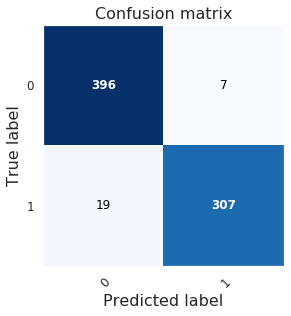

In [16]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(eval_df["fake"], y_test_pred, 
                           classes=np.array([0,1]),
                           title='Confusion matrix',
                           size=5)

Confusion matrix, without normalization
[[396   7]
 [ 19 307]]


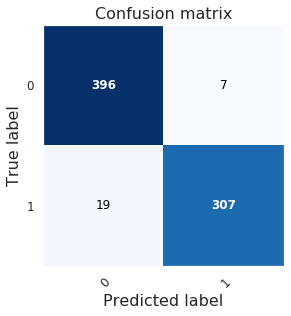

In [17]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(df_news[df_news["train"] == False]["fake"], 
                           df_news[df_news["train"] == False]["fake_pred"], 
                           classes=np.array([0,1]),
                           title='Confusion matrix',
                           size=5)

Normalized confusion matrix
[[0.98263027 0.01736973]
 [0.05828221 0.94171779]]


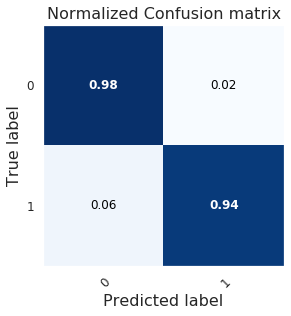

In [18]:
# Plot normalized confusion matrix
ax = plot_confusion_matrix(df_news[df_news["train"] == False]["fake"], 
                           df_news[df_news["train"] == False]["fake_pred"], 
                           classes=np.array([0,1]), normalize=True,
                           title='Normalized Confusion matrix', size=5)

##### By Newspapers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[0.97029703 0.02970297]
 [       nan        nan]]
Normalized confusion matrix
[[0.97029703 0.02970297]
 [       nan        nan]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[1.]]
Normalized confusion matrix
[[0.97802198 0.02197802]
 [       nan        nan]]
Normalized confusion matrix
[[0.97802198 0.02197802]
 [       nan        nan]]
Normalized confusion matrix
[[       nan        nan]
 [0.03571429 0.96428571]]
Normalized confusion matrix
[[       nan        nan]
 [0.03571429 0.96428571]]
Normalized confusion matrix
[[       nan        nan]
 [0.10144928 0.89855072]]
Normalized confusion matrix
[[       nan        nan]
 [0.10144928 0.89855072]]
Normalized confusion matrix
[[       nan        nan]
 [0.08196721 0.91803279]]
Normalized confusion matrix
[[       nan        nan]
 [0.08196721 0.91803279]]


'fig, arr_ax3 = plt.subplots(8,1)\narr_ax3[0] = list_ax[0]\narr_ax3[1] = list_ax[1]\narr_ax3[2] = list_ax[2]\narr_ax3[3] = list_ax[3]\narr_ax3[4] = list_ax[4]\narr_ax3[5] = list_ax[5]\narr_ax3[6] = list_ax[6]\narr_ax3[7] = list_ax[7]'

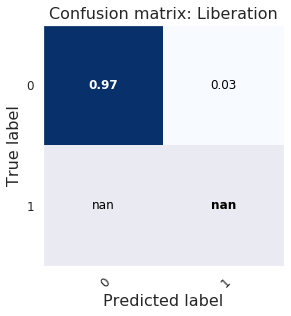

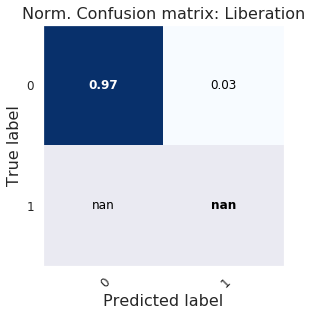

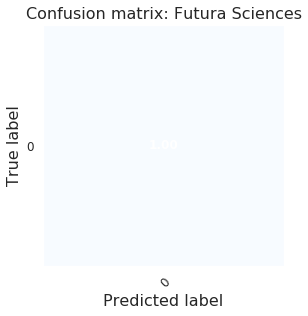

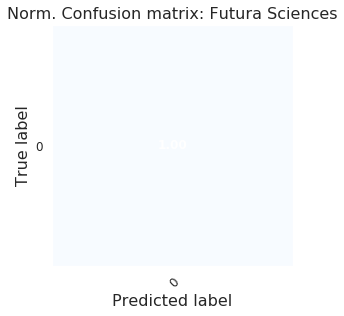

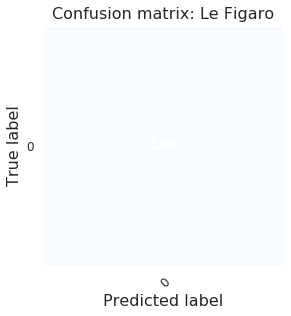

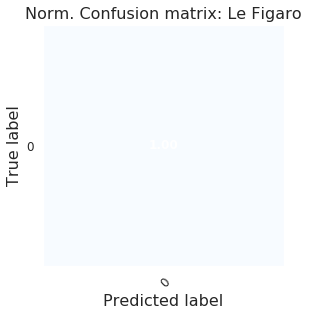

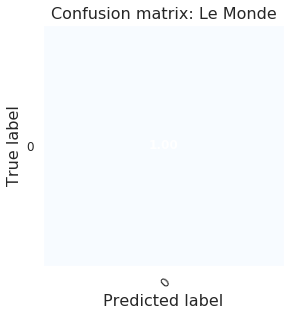

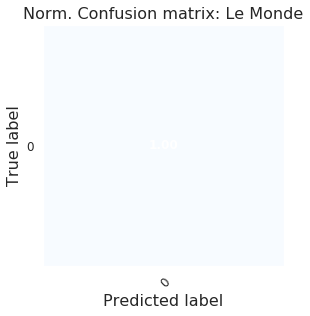

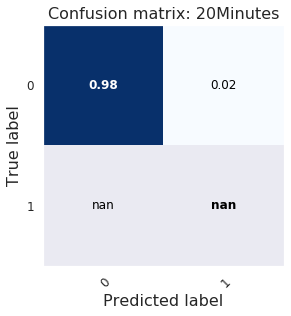

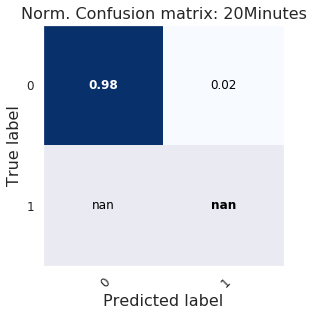

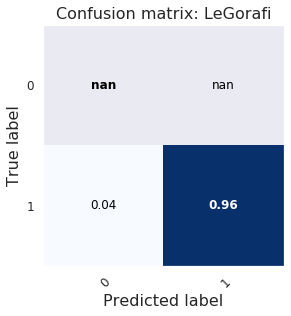

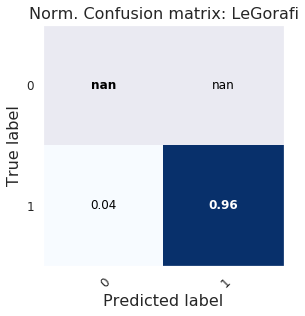

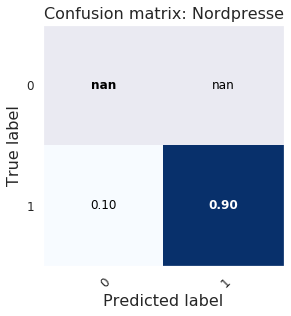

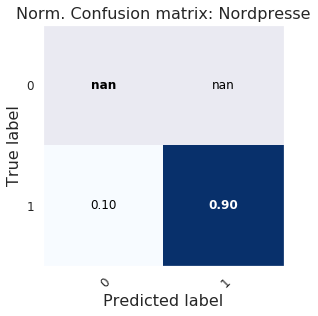

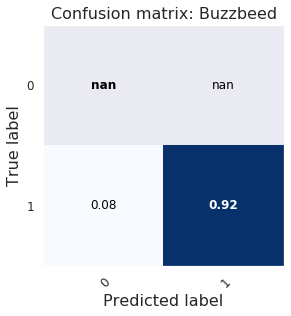

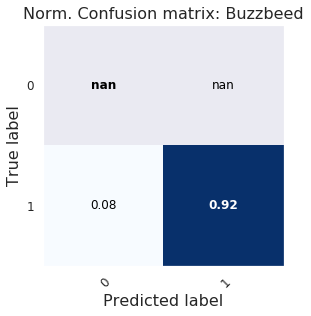

In [19]:
# Plot  confusion matrix

list_ax =[]
for I, newspaper_curr in enumerate(df_news["source"].unique()):
  indices = (df_news["train"] == False) & (df_news["source"] == newspaper_curr)
  
  list_ax.append(plot_confusion_matrix(df_news[indices]["fake"], 
                           df_news[indices]["fake_pred"], 
                           classes=np.array([0,1]), normalize=True,
                           title='Confusion matrix: '+  newspaper_curr, size=5))
  
  list_ax.append(plot_confusion_matrix(df_news[indices]["fake"], 
                           df_news[indices]["fake_pred"], 
                           classes=np.array([0,1]), normalize=True,
                           title='Norm. Confusion matrix: ' +  newspaper_curr, 
                           size=5))
  #list_ax.append(arr_ax)
  #list_ax.append(arr_ax2)

'''fig, arr_ax3 = plt.subplots(8,1)
arr_ax3[0] = list_ax[0]
arr_ax3[1] = list_ax[1]
arr_ax3[2] = list_ax[2]
arr_ax3[3] = list_ax[3]
arr_ax3[4] = list_ax[4]
arr_ax3[5] = list_ax[5]
arr_ax3[6] = list_ax[6]
arr_ax3[7] = list_ax[7]'''

#### False Positives

In [0]:
df_news["fp"] = (df_news["fake"] == 0)&(df_news["fake_pred"] == 1)

In [21]:
df_news[df_news["fp"] == True]

url  ... fn_logreg
214   https://www.liberation.fr/planete/2018/11/28/u...  ...     False
394   https://www.liberation.fr/planete/2019/12/16/l...  ...     False
683   https://www.liberation.fr/france/2019/12/23/a-...  ...     False
971   https://www.20minutes.fr/societe/2671323-20191...  ...     False
1042  https://www.20minutes.fr/rennes/2662083-201911...  ...     False
1149  https://www.20minutes.fr/arts-stars/people/264...  ...     False
1316  https://www.20minutes.fr/societe/2683079-20191...  ...     False

[7 rows x 18 columns]

In [22]:
# count all news by sources
s_source = df_news.source.value_counts(sort=False)
# count false positives by sources
s_source_fp = df_news[df_news["fp"] == True].source.value_counts(sort=False)
# label True news sources
list_true_sources = df_news[df_news["fake"] == 0]["source"].unique()
# calculate repartition of false positive by sources
s_pc_fp = s_source.filter(items=list_true_sources).astype('float')
for source_name in s_pc_fp.index:
  if source_name in s_source_fp.index.tolist():
    #print("{} / {}".format(s_source_fp[source_name], s_pc_fp[source_name]))
    s_pc_fp[source_name] = 100*s_source_fp[source_name]/s_pc_fp[source_name]
  else:
    s_pc_fp[source_name] = 0
s_pc_fp

Liberation         0.900901
Futura Sciences    0.000000
Le Figaro          0.000000
Le Monde           0.000000
20Minutes          0.683761
Name: source, dtype: float64

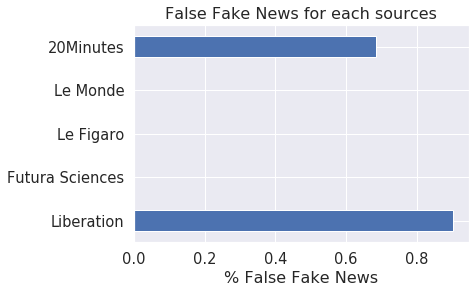

In [23]:
ax = s_pc_fp.plot.barh()
ax.set_title("False Fake News for each sources")
ax.set_xlabel("% False Fake News");

In [24]:
# count all news by themes
s_theme = df_news["theme"].value_counts(sort=False)
# count false positives by themes
s_theme_fp = df_news[df_news["fp"] == True].theme.value_counts(sort=False)
# label True news themes
list_true_themes = df_news[df_news["fake"] == 0]["theme"].unique()
# calculate repartition of false positive by sources
s_pc_fp = s_theme.filter(items=list_true_themes).astype('float')
for theme_name in s_pc_fp.index:
  if theme_name in s_theme_fp.index.tolist():
    print("{} / {}".format(s_theme_fp[theme_name], s_pc_fp[theme_name]))
    s_pc_fp[theme_name] = 100*s_theme_fp[theme_name]/s_pc_fp[theme_name]
  else:
    s_pc_fp[theme_name] = 0
s_pc_fp

1 / 282.0
2 / 201.0
3 / 605.0
1 / 523.0


france             0.354610
sante              0.000000
tech               0.000000
sciences           0.000000
planete            0.995025
debats             0.000000
sports             0.000000
chroniques         0.000000
article            0.000000
maison             0.000000
actu conseils      0.000000
economie           0.000000
politique          0.495868
evenements libe    0.000000
culture            0.000000
monde              0.000000
m perso            0.000000
societe            0.191205
idees              0.000000
m le mag           0.000000
police justice     0.000000
Name: theme, dtype: float64

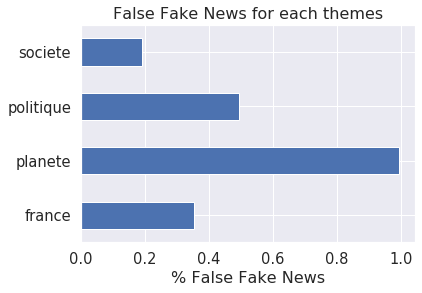

In [25]:
#fig = plt.figure(figsize=(8, 8))
ax = s_pc_fp[s_pc_fp.values>0].plot.barh()
ax.set_title("False Fake News for each themes")
ax.set_xlabel("% False Fake News");

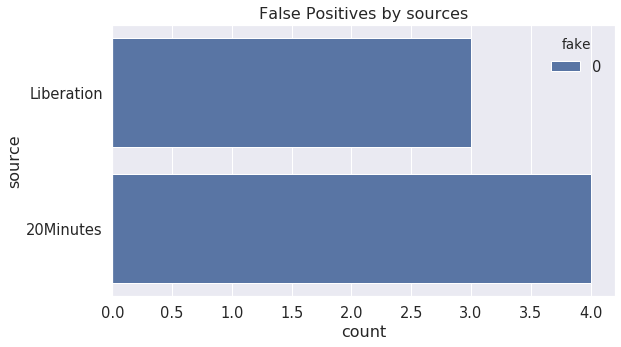

In [26]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("False Positives by sources")
ax = sns.countplot(y="source", hue="fake", 
              data=df_news[df_news["fp"] == True])

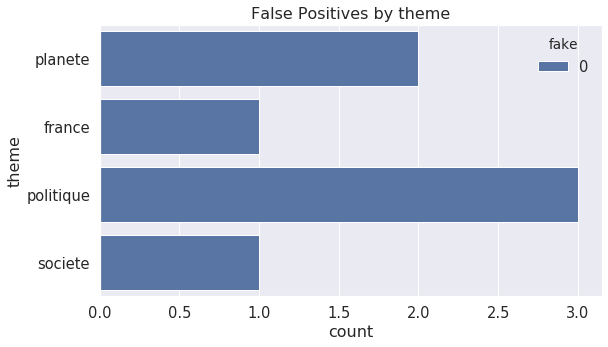

In [27]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("False Positives by theme")
ax = sns.countplot(y="theme", hue="fake", 
              data=df_news[(df_news["fake"] == 0)&(df_news["fake_pred"] == 1)])

#### False Negatives

In [28]:
df_news["fn"] = (df_news["fake"] == 1)&(df_news["fake_pred"] == 0)
df_news[df_news["fn"] == True]

url  ... fn_logreg
1526  http://www.legorafi.fr/2019/07/08/fact-check-l...  ...      True
1548  http://www.legorafi.fr/2019/05/21/crocodiles-5...  ...      True
1663  http://www.legorafi.fr/2018/08/22/laicite-les-...  ...     False
1675  http://www.legorafi.fr/2018/08/01/departs-en-v...  ...     False
1810  http://www.legorafi.fr/2018/07/17/emmanuel-mac...  ...      True
1981  http://www.legorafi.fr/2018/05/11/sante-8-cons...  ...     False
2064  http://www.legorafi.fr/2015/10/14/archives-du-...  ...     False
2109  https://nordpresse.be/premieres-images-de-la-r...  ...     False
2122  https://nordpresse.be/lubrizol-la-directrice-r...  ...      True
2123  https://nordpresse.be/les-orangs-outans-reloge...  ...      True
2152  https://nordpresse.be/faux-steaks-haches-pour-...  ...     False
2177  https://nordpresse.be/nouveau-depart-dun-cadre...  ...      True
2196  https://nordpresse.be/mounir-mahjoubi-veux-dep...  ...      True
2255  https://nordpresse.be/greve-surprise-a-sncf-ch...  ...      True
2328  https://www.buzzbeed.com/manifestations-anti-g...  ...      True
2347  https://www.buzzbeed.com/linsee-publie-chiffre...  ...      True
2359  https://www.buzzbeed.com/bataclan-nice-londres...  ...     False
2367  https://www.buzzbeed.com/decouvrez-lequitation...  ...     False
2503  https://www.buzzbeed.com/lancement-dune-campag...  ...      True

[19 rows x 18 columns]

In [29]:
# count all news by sources
s_source = df_news.source.value_counts(sort=False)
# count false negatives by sources
s_source_fn = df_news[df_news["fn"] == True].source.value_counts(sort=False)
# label Fake news sources
list_fake_sources = df_news[df_news["fake"] == 1]["source"].unique()
# calculate repartition of false positive by sources
s_pc_fn = s_source.filter(items=list_fake_sources).astype('float')
for source_name in s_pc_fn.index:
  if source_name in s_source_fn.index.tolist():
    print("{} / {}".format(s_source_fn[source_name], s_pc_fn[source_name]))
    s_pc_fn[source_name] = 100*s_source_fn[source_name]/s_pc_fn[source_name]
  else:
    s_pc_fn[source_name] = 0
s_pc_fn

7 / 621.0
7 / 210.0
5 / 240.0


LeGorafi      1.127214
Nordpresse    3.333333
Buzzbeed      2.083333
Name: source, dtype: float64

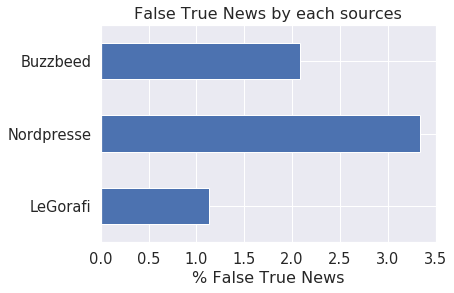

In [30]:
ax = s_pc_fn.plot.barh()
ax.set_title("False True News by each sources")
ax.set_xlabel("% False True News");

In [31]:
# count all news by themes
s_theme = df_news["theme"].value_counts(sort=False)
# count false neg by themes
s_theme_fn = df_news[df_news["fn"] == True].theme.value_counts(sort=False)
# label True news themes
list_fake_themes = df_news[df_news["fake"] == 1]["theme"].unique()
# calculate repartition of false positive by sources
s_pc_fn = s_theme.filter(items=list_fake_themes).astype('float')
for theme_name in s_pc_fn.index:
  if theme_name in s_theme_fn.index.tolist():
    print("{} / {}".format(s_theme_fn[theme_name], s_pc_fn[theme_name]))
    s_pc_fn[theme_name] = 100*s_theme_fn[theme_name]/s_pc_fn[theme_name]
  else:
    s_pc_fn[theme_name] = 0
s_pc_fn

4 / 523.0
4 / 605.0
4 / 282.0
1 / 221.0
1 / 105.0
1 / 20.0
1 / 27.0
1 / 33.0
1 / 201.0
1 / 38.0


societe                   0.764818
politique                 0.661157
france                    1.418440
economie                  0.000000
sciences                  0.452489
Culture                   0.000000
tech                      0.952381
Gilets Jaunes             5.000000
Start Up Nation           0.000000
monde                     0.000000
Violence                  0.000000
sports                    0.000000
Religion                  0.000000
medias                    0.000000
People                    0.000000
non classe                3.703704
Honteux                   0.000000
sante                     0.000000
Justice                   0.000000
Sexe                      0.000000
Insolite                  0.000000
Sentiment d'insécurité    3.030303
planete                   0.497512
Justice sociale           0.000000
Vivre ensemble            2.631579
Fait divers               0.000000
Fake news                 0.000000
Name: theme, dtype: float64

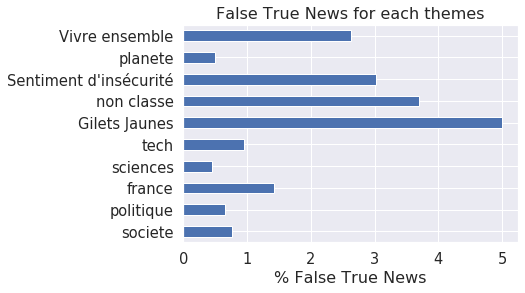

In [32]:
#fig = plt.figure(figsize=(8, 8))
ax = s_pc_fn[s_pc_fn.values>0].plot.barh()
ax.set_title("False True News for each themes")
ax.set_xlabel("% False True News");

#### Save results

In [33]:
# save results into dataFrame
joblib.dump(df_news, PATH_DF_NEWS_SAVE)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/df_news.pkl']

## Cross validation

### Re-load data

In [6]:
# re load data
df_news = joblib.load(PATH_DF_NEWS_SAVE)
df_news.head()

url  ... fn_logreg
1  https://www.liberation.fr/france/2019/12/15/le...  ...     False
2  https://www.futura-sciences.com/sante/actualit...  ...     False
3  https://www.futura-sciences.com/tech/actualite...  ...     False
4  https://www.futura-sciences.com/sciences/actua...  ...     False
6  https://www.futura-sciences.com/sciences/actua...  ...     False

[5 rows x 18 columns]

In [7]:
# Train  data needs to be in a Pandas Dataframe of two columns. 
train_df = df_news.filter(items=["text", "fake"])[df_news["train"] == True]
train_df.head()

text  fake
2  L'origine des comportements alimentaires ident...     0
3  Microsoft alerte sur de nouvelles techniques d...     0
6  Science décalée : la créature la plus rapide s...     0
7  La Terre est en partie faite de poussières de ...     0
8  Grève contre la réforme des retraites, Mario S...     0

### Select splits

In [0]:
# Split parameters
n_splits = 5
test_size = 0.3


# preparation splits : choice of shuffle splits same size and 
# with same % of fake news
cv_fake = model_selection.StratifiedShuffleSplit(n_splits=n_splits, 
                                                 test_size=test_size, 
                                  random_state=RANDOM_STATE)

### Train model on splits

In [10]:
print("% fake in Train :", 
      train_df[train_df["fake"] == 1].shape[0] / train_df.shape[0])
I = 0
for  train_index, test_index in cv_fake.split(train_df["text"], 
                                            train_df["fake"]):

  X_train_curr, X_test_curr = \
    train_df.iloc[train_index], train_df.iloc[test_index]

  pc_f_train = \
    X_train_curr[X_train_curr["fake"] == 1].shape[0] / X_train_curr.shape[0]
  pc_f_test = \
    X_test_curr[X_test_curr["fake"] == 1].shape[0] / X_test_curr.shape[0]

  print("% fake Train split : ", 100*pc_f_train)
  print("% fake Test split : ", 100*pc_f_test)
  path_to_save = PATH_FOLDER_MODEL_SAVED + '_split_{}'.format(I)
  print("path_to_save :", path_to_save)

  train_model_cam(X_train_curr, X_test_curr, path_to_save=path_to_save,
                  use_cuda=True)
  I = I+1


% fake in Train : 0.4374633000587199
% fake Train split :  43.70805369127517
% fake Test split :  43.83561643835616
path_to_save : /content/drive/My Drive/outputs_proj7_split_4
Run # 0


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:139: UserWarning: use_multiprocessing automatically disabled as camembert fails when using multiprocessing for feature conversion.
  warnings.warn(f"use_multiprocessing automatically disabled as {model_type} fails when using multiprocessing for feature conversion.")


Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:183: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")


Running loss: 0.375156

Running loss: 0.033751

Running loss: 0.017239

Running loss: 0.006161

Running loss: 0.001547

Running loss: 0.001143

Running loss: 0.000803

Running loss: 0.000520

Running loss: 0.000430

Running loss: 0.000317

Running loss: 0.000268

Running loss: 0.000182

Running loss: 0.000181

Running loss: 0.000146

Running loss: 0.000139

Running loss: 0.000113

Running loss: 0.000102

Running loss: 0.000076

Running loss: 0.000087

Running loss: 0.000075

Running loss: 0.000086

Running loss: 0.000076

Running loss: 0.000058

Running loss: 0.000065

Running loss: 0.000051

Running loss: 0.000054

Running loss: 0.000047

Running loss: 0.000049

Running loss: 0.000046

Running loss: 0.000044

Running loss: 0.000055

Running loss: 0.000042

Running loss: 0.000054
Training of camembert model complete. Saved to outputs/.
Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:458: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn("Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.")



{'mcc': 0.9403647321511991, 'tp': 215, 'tn': 281, 'fp': 6, 'fn': 9, 'eval_loss': 0.23466150951571763}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.9706457925636007
Run # 1
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1192


Running loss: 0.315063

Running loss: 0.685839

Running loss: 0.012136

Running loss: 0.005343

Running loss: 0.001756

Running loss: 0.001296

Running loss: 0.001112

Running loss: 0.000792

Running loss: 0.000578

Running loss: 0.000395

Running loss: 0.000325

Running loss: 0.000298

Running loss: 0.000195

Running loss: 0.000189

Running loss: 0.000137

Running loss: 0.000133

Running loss: 0.000103

Running loss: 0.000109

Running loss: 0.000144

Running loss: 0.000099

Running loss: 0.000103

Running loss: 0.000077

Running loss: 0.000084

Running loss: 0.000058

Running loss: 0.000063

Running loss: 0.000067

Running loss: 0.000059

Running loss: 0.000061

Running loss: 0.000052

Running loss: 0.000049

Running loss: 0.000047

Running loss: 0.000057

Running loss: 0.000059
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



{'mcc': 0.9483668447091423, 'tp': 218, 'tn': 280, 'fp': 7, 'fn': 6, 'eval_loss': 0.24346412904560566}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.974559686888454
Run # 2
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1192


Running loss: 0.379622

Running loss: 0.021981

Running loss: 0.011562

Running loss: 0.003888

Running loss: 0.002853

Running loss: 0.001053

Running loss: 0.000597

Running loss: 0.000441

Running loss: 0.000377

Running loss: 0.000246

Running loss: 0.000204

Running loss: 0.000193

Running loss: 0.000157

Running loss: 0.000121

Running loss: 0.000144

Running loss: 0.000096

Running loss: 0.000124

Running loss: 0.000108

Running loss: 0.000080

Running loss: 0.000098

Running loss: 0.000164

Running loss: 0.810330

Running loss: 0.000079

Running loss: 0.000103

Running loss: 0.000102

Running loss: 0.000072

Running loss: 0.000096

Running loss: 0.000064

Running loss: 0.000051

Running loss: 0.000056

Running loss: 0.000064

Running loss: 0.000045

Running loss: 0.000045
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



{'mcc': 0.9564146162940148, 'tp': 220, 'tn': 280, 'fp': 7, 'fn': 4, 'eval_loss': 0.207934850427705}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.9784735812133072
Run # 3
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1192


Running loss: 0.339197

Running loss: 0.850398

Running loss: 0.021456

Running loss: 0.104253

Running loss: 0.780437

Running loss: 0.001285

Running loss: 0.000771

Running loss: 0.000554

Running loss: 0.000353

Running loss: 0.000303

Running loss: 0.000347

Running loss: 0.000290

Running loss: 0.000221

Running loss: 0.000195

Running loss: 0.000154

Running loss: 0.000132

Running loss: 0.000113

Running loss: 0.000098

Running loss: 0.000095

Running loss: 0.000087

Running loss: 0.000079

Running loss: 0.000067

Running loss: 0.000063

Running loss: 0.000052

Running loss: 0.000052

Running loss: 0.000056

Running loss: 0.000056

Running loss: 0.000042

Running loss: 0.000048

Running loss: 0.000045

Running loss: 0.000048

Running loss: 0.000044

Running loss: 0.000039
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



{'mcc': 0.948525904622663, 'tp': 214, 'tn': 284, 'fp': 3, 'fn': 10, 'eval_loss': 0.23008139745797962}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.974559686888454
Run # 4
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1192


Running loss: 0.348123

Running loss: 0.474211

Running loss: 0.616844

Running loss: 0.002499

Running loss: 0.001551

Running loss: 0.000799

Running loss: 0.000564

Running loss: 0.000430

Running loss: 0.000255

Running loss: 0.000240

Running loss: 0.000193

Running loss: 0.000143

Running loss: 0.000167

Running loss: 0.000118

Running loss: 0.000108

Running loss: 0.000097

Running loss: 0.000090

Running loss: 0.000078

Running loss: 0.000066

Running loss: 0.000068

Running loss: 0.000052

Running loss: 0.000067

Running loss: 0.000053

Running loss: 0.000040

Running loss: 0.000037

Running loss: 0.000041

Running loss: 0.000040

Running loss: 0.000047

Running loss: 0.000039

Running loss: 0.000035

Running loss: 0.000028

Running loss: 0.000035

Running loss: 0.000033
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



{'mcc': 0.9403636624274466, 'tp': 216, 'tn': 280, 'fp': 7, 'fn': 8, 'eval_loss': 0.2644350375048816}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.9706457925636007
Run # 5
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1192


Running loss: 0.250810

Running loss: 0.055816

Running loss: 0.007515

Running loss: 0.003855

Running loss: 0.002189

Running loss: 0.000951

Running loss: 0.000668

Running loss: 0.000432

Running loss: 0.000289

Running loss: 0.000240

Running loss: 0.000232

Running loss: 0.000181

Running loss: 0.000148

Running loss: 0.000173

Running loss: 0.000136

Running loss: 0.000118

Running loss: 0.000107

Running loss: 0.000087

Running loss: 0.000068

Running loss: 0.000055

Running loss: 0.000052

Running loss: 0.000069

Running loss: 0.000056

Running loss: 0.000049

Running loss: 0.000036

Running loss: 0.000060

Running loss: 0.000045

Running loss: 0.000046

Running loss: 0.000034

Running loss: 0.000053

Running loss: 0.000041

Running loss: 0.000029

Running loss: 0.000044
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



{'mcc': 0.964256397076314, 'tp': 220, 'tn': 282, 'fp': 5, 'fn': 4, 'eval_loss': 0.15823122841538861}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.9823874755381604
Run # 6
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1192


Running loss: 0.510183

Running loss: 0.019613

Running loss: 0.016248

Running loss: 0.004200

Running loss: 0.002599

Running loss: 0.002455

Running loss: 0.001501

Running loss: 0.000968

Running loss: 0.000556

Running loss: 0.000336

Running loss: 0.000501

Running loss: 0.000315

Running loss: 0.000250

Running loss: 0.000181

Running loss: 0.000186

Running loss: 0.000131

Running loss: 0.000148

Running loss: 0.000103

Running loss: 0.000116

Running loss: 0.000116

Running loss: 0.000123

Running loss: 0.000083

Running loss: 0.000072

Running loss: 0.000076

Running loss: 0.000089

Running loss: 0.000066

Running loss: 0.000065

Running loss: 0.000060

Running loss: 0.000057

Running loss: 0.000070

Running loss: 0.000060

Running loss: 0.000048

Running loss: 0.000056
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



{'mcc': 0.936378412725823, 'tp': 215, 'tn': 280, 'fp': 7, 'fn': 9, 'eval_loss': 0.24293688917532563}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.9686888454011742
Run # 7
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1192


Running loss: 0.506687

Running loss: 0.479200

Running loss: 0.006705

Running loss: 0.002660

Running loss: 0.001947

Running loss: 0.001357

Running loss: 0.000849

Running loss: 0.001656

Running loss: 0.000721

Running loss: 0.000473

Running loss: 0.000283

Running loss: 0.000260

Running loss: 0.000223

Running loss: 0.000175

Running loss: 0.000133

Running loss: 0.000151

Running loss: 0.000124

Running loss: 0.000085

Running loss: 0.000086

Running loss: 0.000087

Running loss: 0.000076

Running loss: 0.000069

Running loss: 0.000067

Running loss: 0.000074

Running loss: 0.000054

Running loss: 0.000055

Running loss: 0.000046

Running loss: 0.000057

Running loss: 0.000051

Running loss: 0.000041

Running loss: 0.000040

Running loss: 0.000045

Running loss: 0.000046
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



{'mcc': 0.940425651768424, 'tp': 214, 'tn': 282, 'fp': 5, 'fn': 10, 'eval_loss': 0.2762776673771441}
Converting to features started. Cache is not used.



acc_train:  0.9991610738255033
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.9706457925636007
Run # 8
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1192


Running loss: 0.344827

Running loss: 0.019374

Running loss: 0.681272

Running loss: 0.002310

Running loss: 0.001448

Running loss: 0.001299

Running loss: 0.000638

Running loss: 0.000489

Running loss: 0.000324

Running loss: 0.000254

Running loss: 0.000231

Running loss: 0.000194

Running loss: 0.000241

Running loss: 0.000159

Running loss: 0.000131

Running loss: 0.000094

Running loss: 0.000085

Running loss: 0.000093

Running loss: 0.000074

Running loss: 0.000073

Running loss: 0.000074

Running loss: 0.000055

Running loss: 0.000050

Running loss: 0.000039

Running loss: 0.000052

Running loss: 0.000051

Running loss: 0.000040

Running loss: 0.000040

Running loss: 0.000042

Running loss: 0.000036

Running loss: 0.000043

Running loss: 0.000042

Running loss: 0.000035
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



{'mcc': 0.9483162281546482, 'tp': 217, 'tn': 281, 'fp': 6, 'fn': 7, 'eval_loss': 0.18970862892456353}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.974559686888454
Run # 9
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1192


Running loss: 0.375275

Running loss: 0.632887

Running loss: 0.005746

Running loss: 0.743891

Running loss: 0.567175

Running loss: 0.001057

Running loss: 0.000608

Running loss: 0.000579

Running loss: 0.000411

Running loss: 0.000283

Running loss: 0.000239

Running loss: 0.000173

Running loss: 0.000160

Running loss: 0.000150

Running loss: 0.000184

Running loss: 0.000137

Running loss: 0.000122

Running loss: 0.000109

Running loss: 0.000108

Running loss: 0.000084

Running loss: 0.000080

Running loss: 0.000074

Running loss: 0.000070

Running loss: 0.000056

Running loss: 0.000061

Running loss: 0.000042

Running loss: 0.000044

Running loss: 0.000054

Running loss: 0.000045

Running loss: 0.000049

Running loss: 0.000042

Running loss: 0.000043

Running loss: 0.000045
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



{'mcc': 0.9483668447091423, 'tp': 218, 'tn': 280, 'fp': 7, 'fn': 6, 'eval_loss': 0.21051962347701192}
Converting to features started. Cache is not used.



acc_train:  1.0
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_511



acc_test:  0.974559686888454
list_acc_train:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9991610738255033, 1.0, 1.0]
list_acc_test:  [0.9706457925636007, 0.974559686888454, 0.9784735812133072, 0.974559686888454, 0.9706457925636007, 0.9823874755381604, 0.9686888454011742, 0.9706457925636007, 0.974559686888454, 0.974559686888454]
best result:  {'mcc': 0.964256397076314, 'tp': 220, 'tn': 282, 'fp': 5, 'fn': 4, 'eval_loss': 0.15823122841538861}
best acc_test:  1.0
best acc_test:  0.9823874755381604


### Evaluate on splits

In [49]:
scores = []
I = 0
for  train_index, test_index in cv_fake.split(train_df["text"], 
                                            train_df["fake"]):

  X_train_curr, X_test_curr = \
    train_df.iloc[train_index], train_df.iloc[test_index]

  path_to_mdl_curr = PATH_FOLDER_MODEL_SAVED + '_split_{}'.format(I)

  print("path_to_model :", path_to_mdl_curr)

  # load model
  model = ClassificationModel('camembert', path_to_mdl_curr)

  # eval test split (test part of current Train data)
  y_test_pred, raw_outputs = model.predict(X_test_curr["text"].tolist())
  score_curr = accuracy_score(X_test_curr["fake"], y_test_pred)
  scores.append(score_curr)
  print("acc score Test : ", score_curr)
  I = I+1

path_to_model : /content/drive/My Drive/outputs_proj7_split_0
Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:139: UserWarning: use_multiprocessing automatically disabled as camembert fails when using multiprocessing for feature conversion.
  warnings.warn(f"use_multiprocessing automatically disabled as {model_type} fails when using multiprocessing for feature conversion.")



acc score Test :  0.9726027397260274
path_to_model : /content/drive/My Drive/outputs_proj7_split_1
Converting to features started. Cache is not used.



acc score Test :  0.9902152641878669
path_to_model : /content/drive/My Drive/outputs_proj7_split_2
Converting to features started. Cache is not used.



acc score Test :  0.9823874755381604
path_to_model : /content/drive/My Drive/outputs_proj7_split_3
Converting to features started. Cache is not used.



acc score Test :  0.9823874755381604
path_to_model : /content/drive/My Drive/outputs_proj7_split_4
Converting to features started. Cache is not used.



acc score Test :  0.9823874755381604


In [50]:
scores  = np.array(scores)
print("Accuracies : ", scores)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), 
                                        1.96*scores.std()/(n_splits)**0.5))

Accuracies :  [0.97260274 0.99021526 0.98238748 0.98238748 0.98238748]
Accuracy: 0.982 (+/- 0.005)


In [74]:
df_res.at["camemBERT","mean_acc_test_splits"] = scores.mean()
df_res.at["camemBERT","error_margin"] = 1.96*scores.std()/(n_splits)**0.5
df_res

acc_train  acc_test  mean_acc_test_splits  error_margin
camemBERT        1.0  0.964335              0.981996        0.0049

##### Save results

In [75]:
try:
  df_res_disk = joblib.load(PATH_DF_RES_SAVE)
  #df_res_in = df_res.copy()
  try:
    df_res_disk.loc["camemBERT"] = df_res.loc["camemBERT"]
    df_res = df_res_disk.copy()
  except:
    df_res_disk.append(df_res)
    df_res = df_res_disk.copy()
except:
  df_res_disk = None
joblib.dump(df_res, PATH_DF_RES_SAVE) 

['/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/df_res.pkl']

In [76]:
df_res

acc_train  acc_test  mean_acc_test_splits  error_margin
camemBERT        1.0  0.964335              0.981996        0.0049

## False Negatives on Test

In [12]:
# count all news by sources
s_source = df_news[df_news["train"] == False].source.value_counts(sort=False)
# count false negatives by sources
s_source_fn = df_news[(df_news["fn"] == True) \
                  & (df_news["train"] == False)].source.value_counts(sort=False)
# label Fake news sources
list_fake_sources = df_news[(df_news["fake"] == 1) & \
                            (df_news["train"] == False)]["source"].unique()
# calculate repartition of false positive by sources
s_pc_fn = s_source.filter(items=list_fake_sources).astype('float')
for source_name in s_pc_fn.index:
  if source_name in s_source_fn.index.tolist():
    print("{} / {}".format(s_source_fn[source_name], s_pc_fn[source_name]))
    s_pc_fn[source_name] = 100*s_source_fn[source_name]/s_pc_fn[source_name]
  else:
    s_pc_fn[source_name] = 0
s_pc_fn

7 / 196.0
7 / 69.0
5 / 61.0


LeGorafi       3.571429
Nordpresse    10.144928
Buzzbeed       8.196721
Name: source, dtype: float64

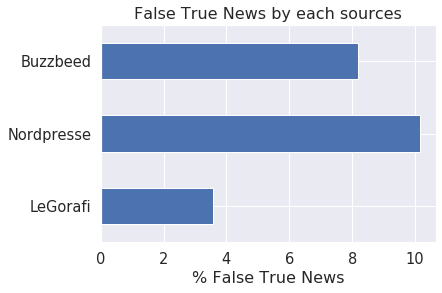

In [13]:
ax = s_pc_fn.plot.barh()
ax.set_title("False True News by each sources")
ax.set_xlabel("% False True News");

In [14]:
# count all news by themes
s_theme = df_news[df_news["train"] == False]["theme"].value_counts(sort=False)
# count false neg by themes
s_theme_fn = df_news[(df_news["fn"] == True) & \
                     (df_news["train"] == False)].theme.value_counts(sort=False)
# label True news themes
list_fake_themes = df_news[(df_news["fake"] == 1) & \
                           (df_news["train"] == False)]["theme"].unique()
# calculate repartition of false positive by sources
s_pc_fn = s_theme.filter(items=list_fake_themes).astype('float')
for theme_name in s_pc_fn.index:
  if theme_name in s_theme_fn.index.tolist():
    print("{} / {}".format(s_theme_fn[theme_name], s_pc_fn[theme_name]))
    s_pc_fn[theme_name] = 100*s_theme_fn[theme_name]/s_pc_fn[theme_name]
  else:
    s_pc_fn[theme_name] = 0
s_pc_fn

4 / 177.0
4 / 178.0
4 / 84.0
1 / 65.0
1 / 31.0
1 / 8.0
1 / 10.0
1 / 58.0
1 / 9.0
1 / 6.0


societe                    2.259887
politique                  2.247191
france                     4.761905
sciences                   1.538462
economie                   0.000000
tech                       3.225806
Honteux                    0.000000
Gilets Jaunes             12.500000
Religion                   0.000000
sante                      0.000000
monde                      0.000000
non classe                10.000000
Insolite                   0.000000
planete                    1.724138
Sentiment d'insécurité    11.111111
Vivre ensemble            16.666667
Fait divers                0.000000
Justice sociale            0.000000
Fake news                  0.000000
Name: theme, dtype: float64

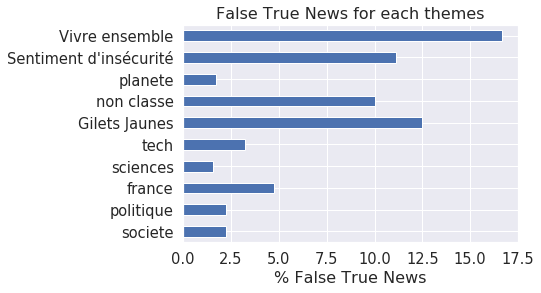

In [15]:
#fig = plt.figure(figsize=(8, 8))
ax = s_pc_fn[s_pc_fn.values>0].plot.barh()
ax.set_title("False True News for each themes")
ax.set_xlabel("% False True News");

## False positives on Test 

In [8]:
# count all news by sources
s_source = df_news[df_news["train"] == False].source.value_counts(sort=False)
# count false positives by sources
s_source_fp = \
  df_news[(df_news["fp"] == True) \
          &(df_news["train"] == False)].source.value_counts(sort=False)
# label True news sources
list_true_sources = df_news[
          (df_news["fake"] == 0)&(df_news["train"] == False)]["source"].unique()
# calculate repartition of false positive by sources
s_pc_fp = s_source.filter(items=list_true_sources).astype('float')
for source_name in s_pc_fp.index:
  if source_name in s_source_fp.index.tolist():
    print("{} / {}".format(s_source_fp[source_name], s_pc_fp[source_name]))
    s_pc_fp[source_name] = 100*s_source_fp[source_name]/s_pc_fp[source_name]
  else:
    s_pc_fp[source_name] = 0

s_pc_fp

3 / 101.0
4 / 182.0


Liberation         2.970297
Futura Sciences    0.000000
Le Figaro          0.000000
Le Monde           0.000000
20Minutes          2.197802
Name: source, dtype: float64

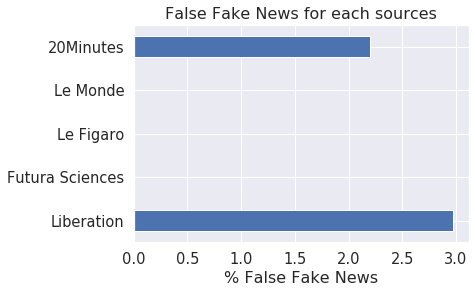

In [9]:
ax = s_pc_fp.plot.barh()
ax.set_title("False Fake News for each sources")
ax.set_xlabel("% False Fake News");

In [10]:
# count all news by themes
s_theme = df_news[df_news["train"] == False]["theme"].value_counts(sort=False)
# count false positives by themes
s_theme_fp = \
  df_news[(df_news["fp"] == True) & \
          (df_news["train"] == False)].theme.value_counts(sort=False)
# label True news themes
list_true_themes = df_news[
  (df_news["fake"] == 0) & (df_news["train"] == False)]["theme"].unique()
# calculate repartition of false positive by sources
s_pc_fp = s_theme.filter(items=list_true_themes).astype('float')
for theme_name in s_pc_fp.index:
  if theme_name in s_theme_fp.index.tolist():
    print("{} / {}".format(s_theme_fp[theme_name], s_pc_fp[theme_name]))
    s_pc_fp[theme_name] = 100*s_theme_fp[theme_name]/s_pc_fp[theme_name]
  else:
    s_pc_fp[theme_name] = 0
s_pc_fp

1 / 84.0
2 / 58.0
3 / 178.0
1 / 177.0


france            1.190476
sciences          0.000000
planete           3.448276
sante             0.000000
tech              0.000000
debats            0.000000
chroniques        0.000000
article           0.000000
maison            0.000000
sports            0.000000
economie          0.000000
actu conseils     0.000000
politique         1.685393
monde             0.000000
societe           0.564972
idees             0.000000
culture           0.000000
police justice    0.000000
Name: theme, dtype: float64

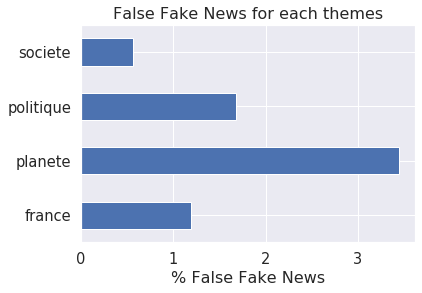

In [11]:
#fig = plt.figure(figsize=(8, 8))
ax = s_pc_fp[s_pc_fp.values>0].plot.barh()
ax.set_title("False Fake News for each themes")
ax.set_xlabel("% False Fake News");